In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import joblib
import warnings
warnings.filterwarnings('ignore')
df=pd.read_csv('/content/dataset.csv')

df.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,total_outstanding_orders
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,df263d996281d984952c07998dc54358,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,f0ade77b43923b38237db569b016ba25,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,f0ade77b43923b38237db569b016ba25,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,f0ade77b43923b38237db569b016ba25,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,f0ade77b43923b38237db569b016ba25,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0


In [ ]:
# Display basic information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 14 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   market_id                 196441 non-null  float64
 1   created_at                197428 non-null  object 
 2   actual_delivery_time      197421 non-null  object 
 3   store_id                  197428 non-null  object 
 4   store_primary_category    192668 non-null  object 
 5   order_protocol            196433 non-null  float64
 6   total_items               197428 non-null  int64  
 7   subtotal                  197428 non-null  int64  
 8   num_distinct_items        197428 non-null  int64  
 9   min_item_price            197428 non-null  int64  
 10  max_item_price            197428 non-null  int64  
 11  total_onshift_partners    181166 non-null  float64
 12  total_busy_partners       181166 non-null  float64
 13  total_outstanding_orders  181166 non-null  f

In [ ]:
df.isna().sum()

,0
market_id,987
created_at,0
actual_delivery_time,7
store_id,0
store_primary_category,4760
order_protocol,995
total_items,0
subtotal,0
num_distinct_items,0
min_item_price,0


In [ ]:
# Fill missing 'store_primary_category' with a placeholder
df['store_primary_category'].fillna('unknown', inplace=True)

# Fill other missing numeric columns with their median
df.fillna({
    'market_id': df['market_id'].median(),
    'order_protocol': df['order_protocol'].median(),
    'total_onshift_partners': df['total_onshift_partners'].median(),
    'total_busy_partners': df['total_busy_partners'].median(),
    'total_outstanding_orders': df['total_outstanding_orders'].median()
}, inplace=True)


In [ ]:
df.isna().sum()

,0
market_id,0
created_at,0
actual_delivery_time,7
store_id,0
store_primary_category,0
order_protocol,0
total_items,0
subtotal,0
num_distinct_items,0
min_item_price,0


In [ ]:
#Convert created_at and actual_delivery_time to datetime
df['created_at'] = pd.to_datetime(df['created_at'])
df['actual_delivery_time'] = pd.to_datetime(df['actual_delivery_time'])

# Calculate delivery time (target variable)
df['delivery_time'] = (df['actual_delivery_time'] - df['created_at']).dt.total_seconds() / 60.0


In [ ]:
#Handle Outliers
# Remove extreme outliers in delivery time
df = df[df['delivery_time'].between(df['delivery_time'].quantile(0.01), df['delivery_time'].quantile(0.99))]


In [ ]:
#Categorical Encoding

df.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,total_outstanding_orders,delivery_time
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,df263d996281d984952c07998dc54358,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,62.983333
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,f0ade77b43923b38237db569b016ba25,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,67.066667
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,f0ade77b43923b38237db569b016ba25,unknown,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,29.683333
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,f0ade77b43923b38237db569b016ba25,unknown,1.0,6,6900,5,600,1800,1.0,1.0,2.0,51.250000
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,f0ade77b43923b38237db569b016ba25,unknown,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,39.833333


In [ ]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

df['store_primary_category'] = encoder.fit_transform(df['store_primary_category'])



In [ ]:
df.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,total_outstanding_orders,delivery_time
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,df263d996281d984952c07998dc54358,4,1.0,4,3441,4,557,1239,33.0,14.0,21.0,62.983333
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,f0ade77b43923b38237db569b016ba25,47,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,67.066667
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,f0ade77b43923b38237db569b016ba25,71,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,29.683333
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,f0ade77b43923b38237db569b016ba25,71,1.0,6,6900,5,600,1800,1.0,1.0,2.0,51.250000
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,f0ade77b43923b38237db569b016ba25,71,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,39.833333


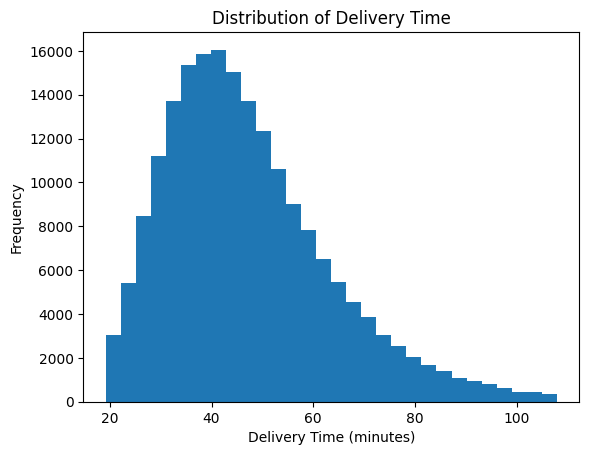

In [ ]:
#Exploratory Data Analysis (EDA)
#Univariate Analysis

# Histogram for delivery_time
plt.hist(df['delivery_time'], bins=30)
plt.title('Distribution of Delivery Time')
plt.xlabel('Delivery Time (minutes)')
plt.ylabel('Frequency')
plt.show()


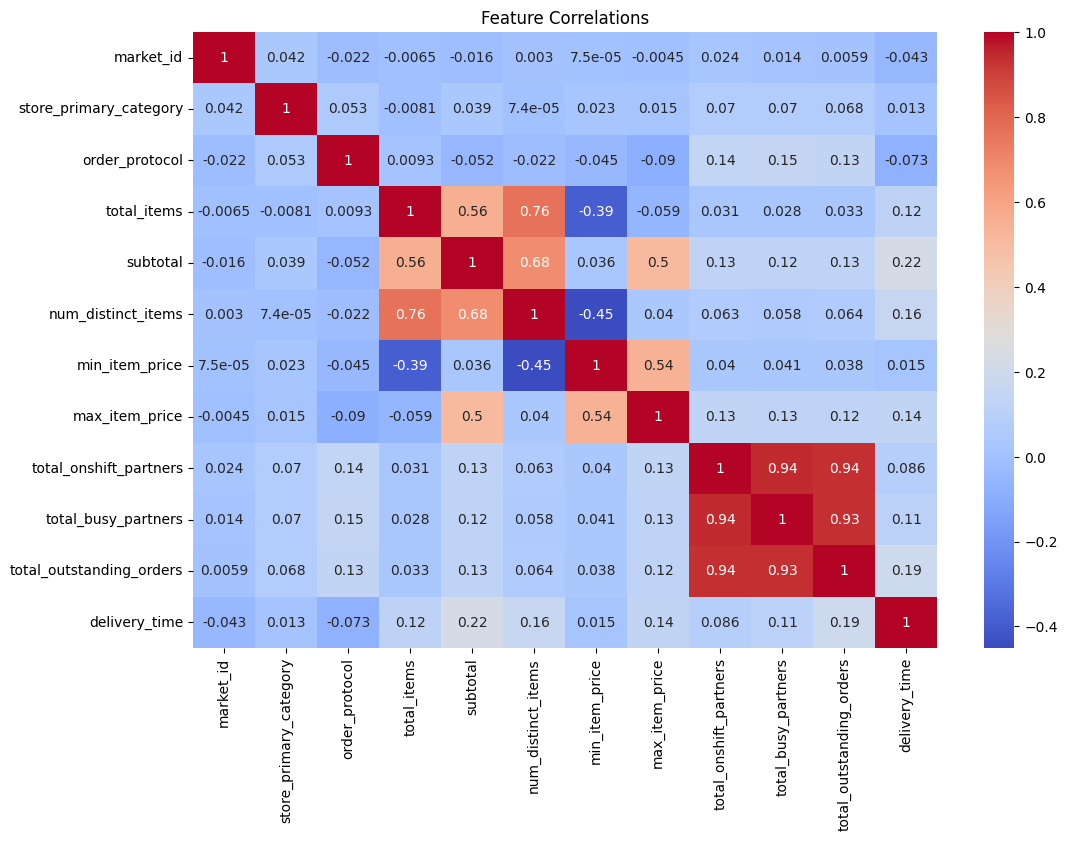

In [ ]:
#Bivariate Analysis
# Correlation Heatmap
correlation = df.corr(numeric_only=True)
plt.figure(figsize=(12,8))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Feature Correlations')
plt.show()


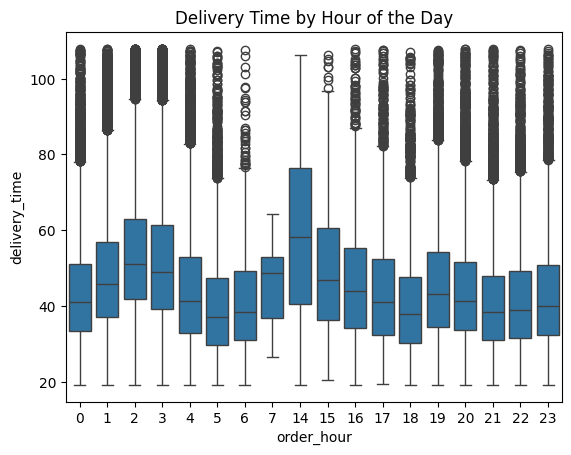

In [ ]:
#Time-based Patterns
# Extract hour, day of the week, and month from 'created_at'
df['order_hour'] = df['created_at'].dt.hour
df['order_day_of_week'] = df['created_at'].dt.dayofweek
df['order_month'] = df['created_at'].dt.month

# Boxplot of delivery time vs. hour of the day
sns.boxplot(x='order_hour', y='delivery_time', data=df)
plt.title('Delivery Time by Hour of the Day')
plt.show()


In [ ]:
#Feature Engineering

# Price Ratios
df['min_max_price_ratio'] = df['min_item_price'] / df['max_item_price']



In [ ]:
df.dropna(axis=0,inplace=True)

In [ ]:
df.isna().sum()

,0
market_id,0
created_at,0
actual_delivery_time,0
store_id,0
store_primary_category,0
order_protocol,0
total_items,0
subtotal,0
num_distinct_items,0
min_item_price,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 193467 entries, 0 to 197427
Data columns (total 19 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   market_id                 193467 non-null  float64       
 1   created_at                193467 non-null  datetime64[ns]
 2   actual_delivery_time      193467 non-null  datetime64[ns]
 3   store_id                  193467 non-null  object        
 4   store_primary_category    193467 non-null  int64         
 5   order_protocol            193467 non-null  float64       
 6   total_items               193467 non-null  int64         
 7   subtotal                  193467 non-null  int64         
 8   num_distinct_items        193467 non-null  int64         
 9   min_item_price            193467 non-null  int64         
 10  max_item_price            193467 non-null  int64         
 11  total_onshift_partners    193467 non-null  float64       
 12  total_b

In [ ]:
df.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,total_outstanding_orders,delivery_time,order_hour,order_day_of_week,order_month,min_max_price_ratio
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,df263d996281d984952c07998dc54358,4,1.0,4,3441,4,557,1239,33.0,14.0,21.0,62.983333,22,4,2,0.449556
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,f0ade77b43923b38237db569b016ba25,47,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,67.066667,21,1,2,1.000000
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,f0ade77b43923b38237db569b016ba25,71,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,29.683333,20,3,1,1.000000
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,f0ade77b43923b38237db569b016ba25,71,1.0,6,6900,5,600,1800,1.0,1.0,2.0,51.250000,21,1,2,0.333333
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,f0ade77b43923b38237db569b016ba25,71,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,39.833333,2,6,2,0.687500


In [ ]:
#Data Splitting
# Define features and target variable
X = df.drop(['created_at', 'actual_delivery_time', 'delivery_time', 'store_id'], axis=1)
y = df['delivery_time']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [ ]:
np.isinf(X_train).sum()

,0
market_id,0
store_primary_category,0
order_protocol,0
total_items,0
subtotal,0
num_distinct_items,0
min_item_price,0
max_item_price,0
total_onshift_partners,0
total_busy_partners,0


In [ ]:
X_train.isna().sum()

,0
market_id,0
store_primary_category,0
order_protocol,0
total_items,0
subtotal,0
num_distinct_items,0
min_item_price,0
max_item_price,0
total_onshift_partners,0
total_busy_partners,0


In [ ]:
X_test.isna().sum()

,0
market_id,0
store_primary_category,0
order_protocol,0
total_items,0
subtotal,0
num_distinct_items,0
min_item_price,0
max_item_price,0
total_onshift_partners,0
total_busy_partners,0


In [ ]:
#Modeling
#Linear Regression (Baseline)
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predictions and evaluation
y_pred_lr = lr_model.predict(X_test)
print("Linear Regression - MAE:", mean_absolute_error(y_test, y_pred_lr))
print("Linear Regression - RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lr)))
print("Linear Regression - R^2:", r2_score(y_test, y_pred_lr))


Linear Regression - MAE: 11.389441722325186
Linear Regression - RMSE: 14.635669332465856
Linear Regression - R^2: 0.17708792018881425


In [ ]:
#Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Predictions and evaluation
y_pred_rf = rf_model.predict(X_test)
print("Random Forest - MAE:", mean_absolute_error(y_test, y_pred_rf))
print("Random Forest - RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))
print("Random Forest - R^2:", r2_score(y_test, y_pred_rf))


Random Forest - MAE: 10.780924862243316
Random Forest - RMSE: 13.87254726874154
Random Forest - R^2: 0.2606659867086246


In [ ]:
#Gradient Boosting Regressor
gb_model = GradientBoostingRegressor(random_state=42)
gb_model.fit(X_train, y_train)

# Predictions and evaluation
y_pred_gb = gb_model.predict(X_test)
print("Gradient Boosting - MAE:", mean_absolute_error(y_test, y_pred_gb))
print("Gradient Boosting - RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_gb)))
print("Gradient Boosting - R^2:", r2_score(y_test, y_pred_gb))


Gradient Boosting - MAE: 10.952142989539533
Gradient Boosting - RMSE: 14.089544548564374
Gradient Boosting - R^2: 0.23735545353225118


#Feature Selection

In [ ]:
rf_model.feature_importances_

array([0.03169375, 0.0736186 , 0.03775216, 0.0219802 , 0.14242638,
       0.0201917 , 0.07301341, 0.08841246, 0.09829904, 0.0601835 ,
       0.11043488, 0.09737446, 0.0594127 , 0.02170722, 0.06349954])

In [ ]:
X.columns

Index(['market_id', 'store_primary_category', 'order_protocol', 'total_items',
       'subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price',
       'total_onshift_partners', 'total_busy_partners',
       'total_outstanding_orders', 'order_hour', 'order_day_of_week',
       'order_month', 'min_max_price_ratio'],
      dtype='object')

In [ ]:
imp_df = pd.DataFrame({i:j for i,j in zip(X.columns,rf_model.feature_importances_)},index=
             [0]).T.sort_values(by=0,ascending=False)


imp_df

,0
subtotal,0.142426
total_outstanding_orders,0.110435
total_onshift_partners,0.098299
order_hour,0.097374
max_item_price,0.088412
store_primary_category,0.073619
min_item_price,0.073013
min_max_price_ratio,0.063500
total_busy_partners,0.060184
order_day_of_week,0.059413


In [ ]:
imp_cols = imp_df.head(7).index.to_list()
imp_cols

['subtotal',
 'total_outstanding_orders',
 'total_onshift_partners',
 'order_hour',
 'max_item_price',
 'store_primary_category',
 'min_item_price']

In [ ]:
#Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train[imp_cols], y_train)

# Predictions and evaluation
y_pred_rf = rf_model.predict(X_test[imp_cols])
print("Random Forest - MAE:", mean_absolute_error(y_test, y_pred_rf))
print("Random Forest - RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))
print("Random Forest - R^2:", r2_score(y_test, y_pred_rf))


Random Forest - MAE: 11.19082393405987
Random Forest - RMSE: 14.396367250199818
Random Forest - R^2: 0.20377814549939588


#Saving Model

In [ ]:
import pickle
pickle.dump(rf_model,open('model.pkl','wb'))

#Model Inference

In [ ]:
sample_input = {
    'subtotal': 5000,
    'total_outstanding_orders': 15,
    'total_onshift_partners': 10,
    'order_hour': 13,
    'max_item_price': 1500,
    'store_primary_category': 1,
    'min_item_price': 300
}

In [ ]:
model = pickle.load(open('/content/model.pkl','rb'))

model

RandomForestRegressor(random_state=42)

In [ ]:
model.predict([list(sample_input.values())])

array([48.16183333])